X_shortcut = X # Store the initial value of X in a variable
#### Perform convolution + batch norm operations on X
X = Add()([X, X_shortcut]) # SKIP Connection

- Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different.
- The **identity block** is the standard block used in ResNets and corresponds to the case where the input activation (say a[l]) has the same dimension as the output activation (say a[l+2]). Below is an example of identity block where the upper path is the “shortcut path” and the lower path is the “main path”.
![title](https://miro.medium.com/max/1400/1*uyXEvYztiv3fGGCCPbm8Jg.png)

In [1]:
# identify_block
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # save the input value. You'll need this later to add back to the main path
    X_shortcut = X  # Store the initial value of X in a variable
    
    # first component of main path
    X = Conv2D(filters = F1, kernel_size=(1,1), strides = (1,1), padding='valid', name = conv_name_base+'2a', kernel_initializer= glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    # second componenet of main path
    X = Conv2D(filters = F2, kernel_size=(f,f), strides = (1,1), padding='same', name = conv_name_base+'2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    # third
    X = Conv2D(filters = F3, kernel_size=(1,1), strides = (1,1), padding='valid', name = conv_name_base+'2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2c')(X)
    X = Activation('relu')(X)
    
    # IFinal step : Add shortcut value to main path, and pass it through a RELU activation
    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

#### Convolutional Block
When the input and output dimensions don’t match up, we add a convolutional layer in the shortcut path. The arrangement is called convolutional block.

In [38]:
def convolutional_block(X, f, filters, stage, block, s =2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # save the input value
    X_shortcut = X
    
    #### MAIN PATH ####
    # First component of main path
    X = Conv2D(F1, (1,1), strides=(s, s), name=conv_name_base+'2a', kernel_initializer= glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # second component of main path
    X = Conv2D(F2, (f,f), strides=(1, 1), padding = 'same', name=conv_name_base+'2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path
    X = Conv2D(F3, (1,1), strides=(1, 1), name=conv_name_base+'2C', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ######
    X_shortcut = Conv2D(F3, (1,1), strides = (s, s), name = conv_name_base+'1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    x_shortcut = BatchNormalization(axis=3, name = bn_name_base + '1')(X_shortcut)
    
    # CFinal step : Add shortcut value to main path, and pass it through a RELU activation
    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [41]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.initializers import glorot_uniform
input_shape = (64, 64, 3)
classes = 6

# Define the input as a tensor with shape input_shape
X_input = Input(input_shape)

# Zero-Padding
X = ZeroPadding2D((3, 3))(X_input)

# Stage 1
X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)

# Stage 2
X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

# Stage 3
X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

# Stage 4
X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

# Stage 5
X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

# AVGPOOL
X = AveragePooling2D((2,2), name='avg_pool')(X)

# output layer
X = Flatten()(X)
X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)

# Create model
model = Model(inputs = X_input, outputs = X, name='ResNet50')

#Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




In [42]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_15 (ZeroPadding2 (None, 70, 70, 3)    0           input_17[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_15[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

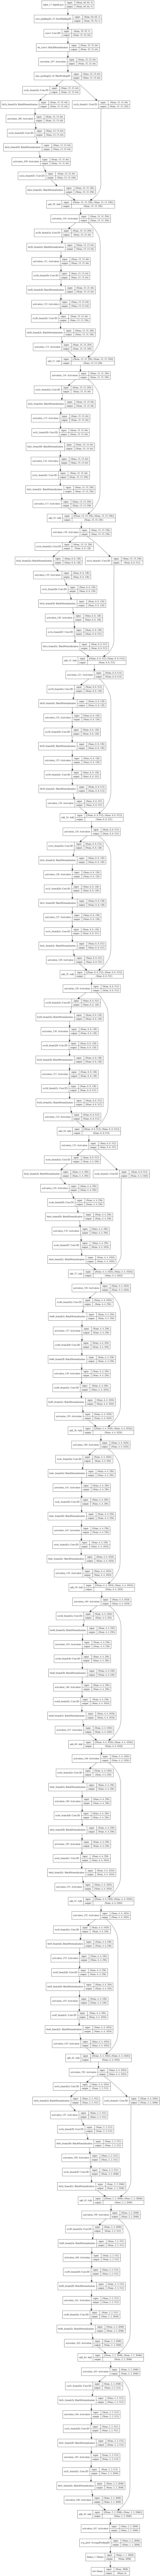

In [43]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
# function for creating an identity residual module
def residual_module(layer_in, n_filters):
	# conv1
	conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv2
	conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
	# add filters, assumes filters/channels last
	layer_out = add([conv2, layer_in])
	# activation function
	layer_out = Activation('relu')(layer_out)
	return layer_out

update ; that will use the identity if possible, otherwise a projection of the number of filters in the input does not match the n_filters argument.

In [3]:
# function for creating an identity or projection residual module
def residual_module(layer_in, n_filters):
	merge_input = layer_in
	# check if the number of filters needs to be increase, assumes channels last format
	if layer_in.shape[-1] != n_filters:
		merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv1
	conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv2
	conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
	# add filters, assumes filters/channels last
	layer_out = add([conv2, merge_input])
	# activation function
	layer_out = Activation('relu')(layer_out)
	return layer_out

In [4]:
# example of a CNN model with an identity or projection residual module
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import add
from keras.utils import plot_model
 
# function for creating an identity or projection residual module
def residual_module(layer_in, n_filters):
	merge_input = layer_in
	# check if the number of filters needs to be increase, assumes channels last format
	if layer_in.shape[-1] != n_filters:
		merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv1
	conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv2
	conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
	# add filters, assumes filters/channels last
	layer_out = add([conv2, merge_input])
	# activation function
	layer_out = Activation('relu')(layer_out)
	return layer_out
 
# define model input
visible = Input(shape=(256, 256, 3))
# add vgg module
layer = residual_module(visible, 64)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 256         input_2[0][0]                    
____________________________________________________________________________________________

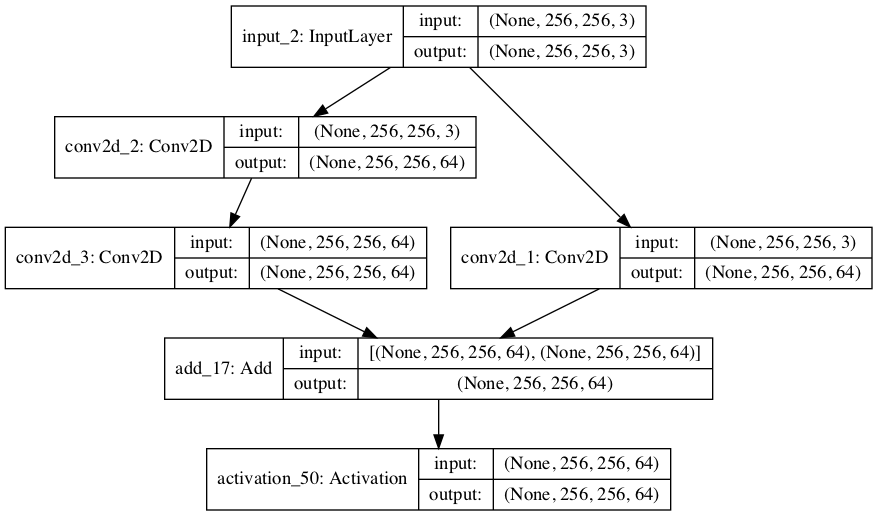

In [5]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='residual_module.png')